In [1]:
# ============================================
# XGBOOST - PHISHING URL DETECTION
# ============================================
# 
# WHAT: Train XGBoost classifier with hyperparameter tuning
# WHY: XGBoost typically outperforms Random Forest
# HOW: Use GridSearchCV for optimal hyperparameters
#
# GOAL: Beat Random Forest baseline (94.86% accuracy, 83.84% recall)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    make_scorer
)
import pickle
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("XGBOOST - PHISHING URL DETECTION")
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

XGBOOST - PHISHING URL DETECTION
Started at: 2025-10-24 21:17:03


In [2]:
# ============================================
# STEP 1: LOAD PROCESSED DATA
# ============================================

print("LOADING DATA")

# Define paths
TRAIN_PATH = '../../../data/processed/url-detection/phishing_features_train.csv'
TEST_PATH = '../../../data/processed/url-detection/phishing_features_test.csv'

# Load data
print("\nLoading training data...")
train_df = pd.read_csv(TRAIN_PATH)
print(f"Train data loaded: {train_df.shape[0]:,} rows, {train_df.shape[1]} columns")

print("\nLoading test data...")
test_df = pd.read_csv(TEST_PATH)
print(f"Test data loaded: {test_df.shape[0]:,} rows, {test_df.shape[1]} columns")

# Prepare data
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

# Handle missing values
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Encode labels as binary (XGBoost needs 0/1, not strings)
# WHAT: Convert 'benign'/'phish' to 0/1
# WHY: XGBoost requires numerical labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # benign=0, phish=1
y_test_encoded = le.transform(y_test)

print(f"\nData prepared:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train_encoded.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_test: {y_test_encoded.shape}")
print(f"\nLabel encoding: benign=0, phish=1")

# Class distribution
print(f"\nClass distribution:")
unique, counts = np.unique(y_train_encoded, return_counts=True)
for label, count in zip(unique, counts):
    label_name = 'benign' if label == 0 else 'phish'
    print(f"   {label_name} ({label}): {count:,} ({count/len(y_train_encoded)*100:.1f}%)")

LOADING DATA

Loading training data...
Train data loaded: 371,941 rows, 22 columns

Loading test data...
Test data loaded: 36,787 rows, 22 columns

Data prepared:
   X_train: (371941, 21)
   y_train: (371941,)
   X_test: (36787, 21)
   y_test: (36787,)

Label encoding: benign=0, phish=1

Class distribution:
   benign (0): 253,189 (68.1%)
   phish (1): 118,752 (31.9%)


In [12]:
# ============================================
# STEP 3: BASELINE XGBOOST (NO TUNING)
# ============================================

print("BASELINE XGBOOST (DEFAULT PARAMETERS)")

# Calculate scale_pos_weight for imbalanced data
# WHAT: Ratio of negative to positive samples
# WHY: Tells XGBoost how to balance the classes
# FORMULA: scale_pos_weight = count(negative) / count(positive)
n_benign = (y_train_encoded == 0).sum()
n_phish = (y_train_encoded == 1).sum()
scale_pos_weight = n_benign / n_phish

print(f"\nClass imbalance handling:")
print(f"   Benign samples: {n_benign:,}")
print(f"   Phishing samples: {n_phish:,}")
print(f"   Scale_pos_weight: {scale_pos_weight:.2f}")
print(f"   → XGBoost will treat phishing {scale_pos_weight:.0f}x more important")

# Train baseline XGBoost
print("\nTraining baseline XGBoost...")
baseline_start = datetime.now()

baseline_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

baseline_model.fit(X_train, y_train_encoded)

baseline_end = datetime.now()
baseline_time = (baseline_end - baseline_start).total_seconds()

print(f"Baseline training complete!")
print(f"Training time: {baseline_time:.2f} seconds")

# Evaluate baseline
baseline_pred = baseline_model.predict(X_test)
baseline_pred_proba = baseline_model.predict_proba(X_test)[:, 1]
baseline_accuracy = accuracy_score(y_test_encoded, baseline_pred)
baseline_precision = precision_score(y_test_encoded, baseline_pred)
baseline_recall = recall_score(y_test_encoded, baseline_pred)
baseline_f1 = f1_score(y_test_encoded, baseline_pred)

baseline_roc_auc = roc_auc_score(y_test_encoded, baseline_pred_proba)

print("\nBaseline XGBoost Results (No Tuning):")
print(f"   Accuracy:  {baseline_accuracy*100:.2f}%")
print(f"   Precision: {baseline_precision*100:.2f}%")
print(f"   Recall:    {baseline_recall*100:.2f}%")
print(f"   F1-Score:  {baseline_f1*100:.2f}%")

print("\nComparison with Random Forest:")
print(f"   Accuracy:  RF: 94.86% → XGB: {baseline_accuracy*100:.2f}% ({baseline_accuracy*100-94.86:+.2f}%)")
print(f"   Recall:    RF: 83.84% → XGB: {baseline_recall*100:.2f}% ({baseline_recall*100-83.84:+.2f}%)")

BASELINE XGBOOST (DEFAULT PARAMETERS)

Class imbalance handling:
   Benign samples: 253,189
   Phishing samples: 118,752
   Scale_pos_weight: 2.13
   → XGBoost will treat phishing 2x more important

Training baseline XGBoost...
Baseline training complete!
Training time: 0.82 seconds

Baseline XGBoost Results (No Tuning):
   Accuracy:  94.98%
   Precision: 85.86%
   Recall:    86.93%
   F1-Score:  86.39%

Comparison with Random Forest:
   Accuracy:  RF: 94.86% → XGB: 94.98% (+0.12%)
   Recall:    RF: 83.84% → XGB: 86.93% (+3.09%)



CONFUSION MATRIX

Confusion Matrix:
[[29083   965]
 [  881  5858]]

Interpretation:
  True Negatives (TN):  29,083 - Correctly identified benign
  False Positives (FP): 965 - Benign wrongly flagged as phishing
  False Negatives (FN): 881 - Phishing missed!
  True Positives (TP):  5,858 - Correctly identified phishing

Comparison with Random Forest:
  False Negatives: RF: 1,089 → XGB: 881 (-208)
  False Positives: RF: 801 → XGB: 965 (+164)


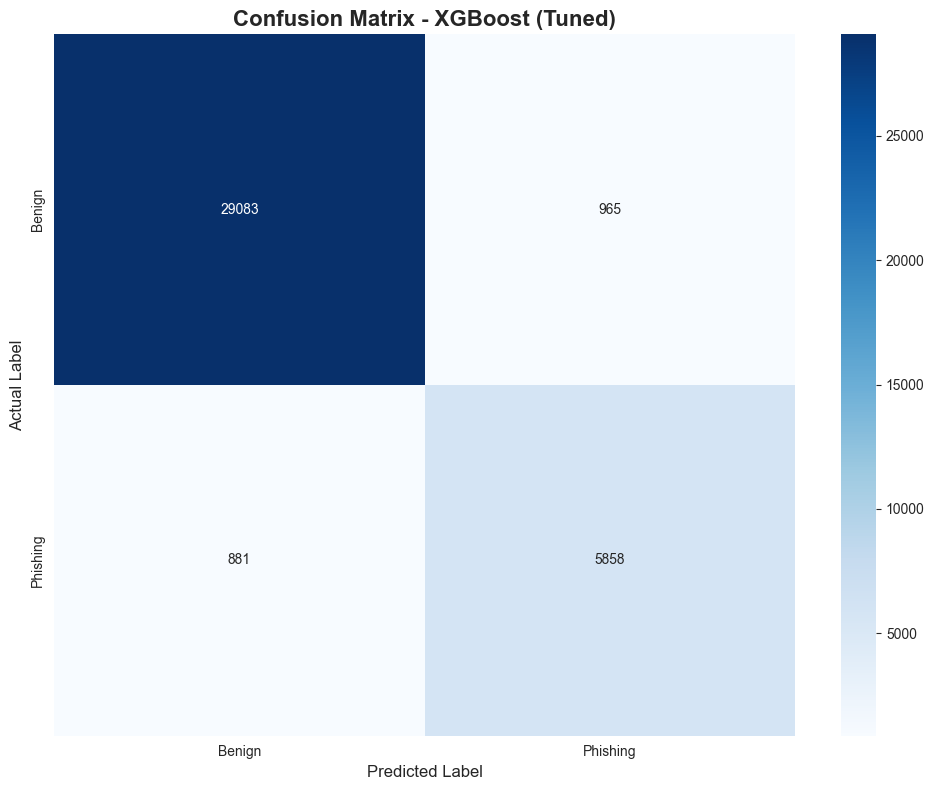


Error Analysis:
  False Positive Rate: 3.21% (benign marked as phishing)
  False Negative Rate: 13.07% (phishing that slipped through)

  Comparison:
  FPR: RF: 2.67% → XGB: 3.21% (+0.54%)
  FNR: RF: 16.16% → XGB: 13.07% (-3.09%)


In [ ]:
# ============================================
# STEP 8: CONFUSION MATRIX
# ============================================

print("CONFUSION MATRIX")

# Calculate confusion matrix
cm = confusion_matrix(y_test_encoded, baseline_pred)

print("\nConfusion Matrix:")
print(cm)
print("\nInterpretation:")
print(f"  True Negatives (TN):  {cm[0,0]:,} - Correctly identified benign")
print(f"  False Positives (FP): {cm[0,1]:,} - Benign wrongly flagged as phishing")
print(f"  False Negatives (FN): {cm[1,0]:,} - Phishing missed!")
print(f"  True Positives (TP):  {cm[1,1]:,} - Correctly identified phishing")

# Compare with Random Forest
print("\nComparison with Random Forest:")
print(f"  False Negatives: RF: 1,089 → XGB: {cm[1,0]:,} ({cm[1,0]-1089:+,})")
print(f"  False Positives: RF: 801 → XGB: {cm[0,1]:,} ({cm[0,1]-801:+,})")

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Phishing'],
            yticklabels=['Benign', 'Phishing'])
plt.title('Confusion Matrix - XGBoost (Tuned)', fontsize=16, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Error rates
fpr = cm[0,1] / (cm[0,0] + cm[0,1])
fnr = cm[1,0] / (cm[1,0] + cm[1,1])

print(f"\nError Analysis:")
print(f"  False Positive Rate: {fpr*100:.2f}% (benign marked as phishing)")
print(f"  False Negative Rate: {fnr*100:.2f}% (phishing that slipped through)")
print(f"\n  Comparison:")
print(f"  FPR: RF: 2.67% → XGB: {fpr*100:.2f}% ({fpr*100-2.67:+.2f}%)")
print(f"  FNR: RF: 16.16% → XGB: {fnr*100:.2f}% ({fnr*100-16.16:+.2f}%)")


ROC CURVE

📈 ROC AUC Score: 0.9810
   Random Forest: 0.9795
   XGBoost: 0.9810
   Improvement: +0.0015


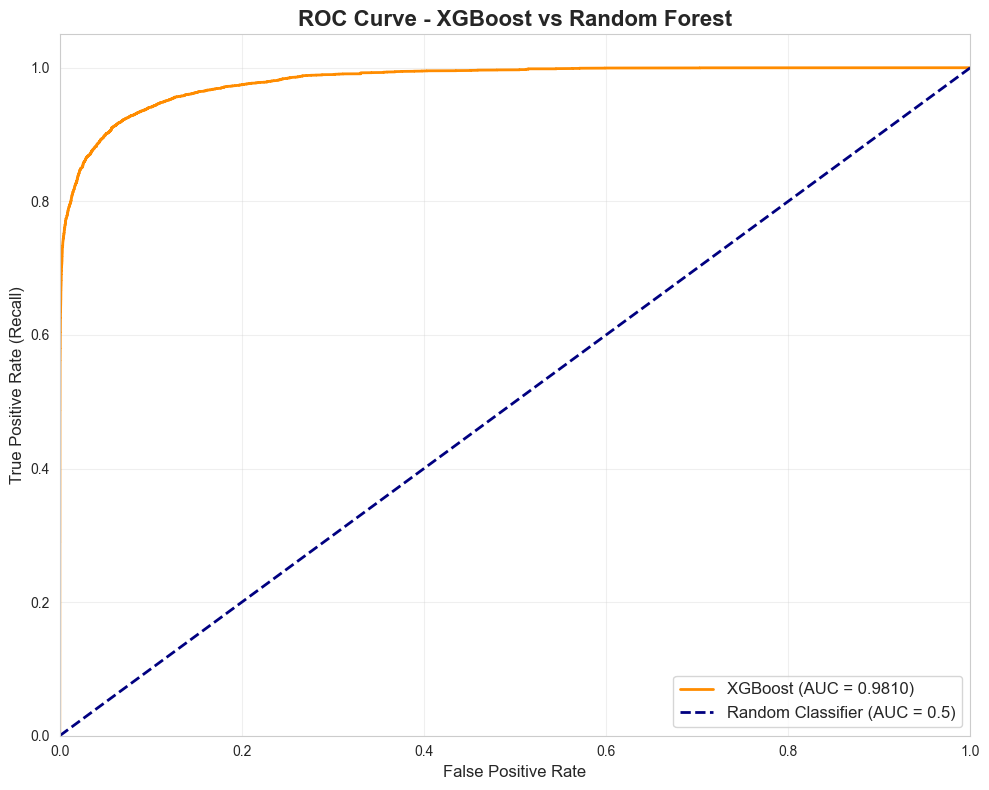

In [ ]:
# ============================================
# STEP 9: ROC CURVE
# ============================================

print("ROC CURVE")

# Calculate ROC curve
fpr_roc, tpr_roc, _ = roc_curve(y_test_encoded, baseline_pred_proba)

print(f"\nROC AUC Score: {baseline_roc_auc:.4f}")
print(f"   Random Forest: 0.9795")
print(f"   XGBoost: {baseline_roc_auc:.4f}")
print(f"   Improvement: {baseline_roc_auc-0.9795:+.4f}")

# Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2,
         label=f'XGBoost (AUC = {baseline_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve - XGBoost vs Random Forest', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


FEATURE IMPORTANCE

📊 Top 20 Most Important Features:
              feature  importance
17       free_hosting    0.298493
19            has_www    0.223314
7         num_slashes    0.141313
8        num_question    0.090511
12           is_https    0.063294
2         path_length    0.037539
18        url_entropy    0.028642
3          tld_length    0.022372
15  num_digits_domain    0.020754
5         num_hyphens    0.014139
1       domain_length    0.012578
4            num_dots    0.011337
20         lang_score    0.009480
13     num_subdomains    0.006985
6     num_underscores    0.006128
10             num_at    0.005155
0          url_length    0.004264
16     suspicious_tld    0.001862
9       num_ampersand    0.000864
14           has_port    0.000500


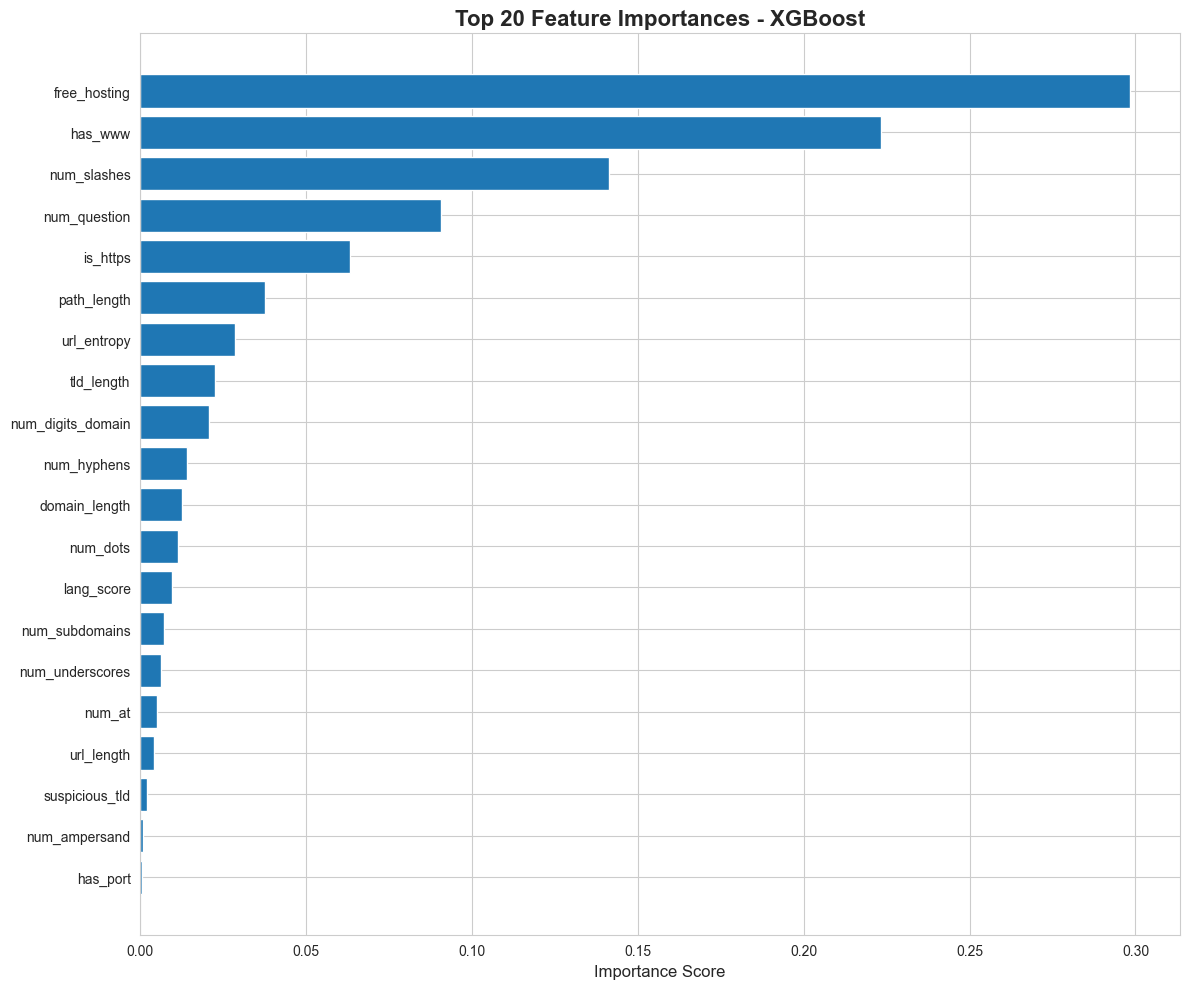

In [ ]:
# ============================================
# STEP 10: FEATURE IMPORTANCE
# ============================================

print("FEATURE IMPORTANCE")

# Get feature importances
feature_names = X_train.columns.tolist()
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': baseline_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Visualize
plt.figure(figsize=(12, 10))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 20 Feature Importances - XGBoost', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [11]:
# ============================================
# STEP 11: SAVE MODEL AND METRICS
# ============================================

print("SAVING MODEL")

# Save model
model_dir = '../../../models/url-detection'
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, 'xgboost.pkl')
print(f"\n💾 Saving model to: {model_path}")

with open(model_path, 'wb') as f:
    pickle.dump(baseline_model, f)

print("✅ Model saved successfully!")


# Model size
model_size = os.path.getsize(model_path) / (1024 * 1024)
print(f"\n📦 Model file size: {model_size:.2f} MB")

SAVING MODEL

💾 Saving model to: ../../../models/url-detection\xgboost.pkl
✅ Model saved successfully!

📦 Model file size: 0.37 MB
